# Analysis of Google Analytics 360 raw logs

With Google Analytics 360, you can access raw logs stored on BigQuery, with detail at hit level. This allows for much more thorough and finer analyses. Here are some examples of audience insights that can be generated with SQL queries only.

## Setup and connection

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery

sns.set()

In [2]:
# Launch BigQuery client from the JSON credentials file
bq_client = bigquery.Client.from_service_account_json('../../bigquery_creds.json')

# Helper function for queries to be returned as a Dataframe
def bquery(sql):
    return bq_client.query(sql).to_dataframe()

## Users, sessions and pageviews

In [3]:
# Sessions and page views for 10 days
sql = """
SELECT 
    PARSE_DATE("%Y%m%d", date) AS date,
    COUNT(DISTINCT fullVisitorId) AS visitors,
    SUM(totals.visits) AS sessions,
    SUM(totals.pageviews) AS pageviews,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170710'
GROUP BY 1
ORDER BY 1
"""
bquery(sql)

,date,visitors,sessions,pageviews
0,2017-07-01,1946,2048,6562
1,2017-07-02,1791,1895,5637
2,2017-07-03,1904,2046,6492
3,2017-07-04,1799,1938,5740
4,2017-07-05,2683,2885,9927
5,2017-07-06,2478,2658,8924
6,2017-07-07,2213,2450,9266
7,2017-07-08,1732,1859,6087
8,2017-07-09,1761,1921,6523
9,2017-07-10,2512,2769,10183


## Breakdown by devices and channels

In [4]:
# Traffic KPIs broken down by device and acquisition channel
sql = """
SELECT 
    device.deviceCategory AS device,
    channelGrouping AS channel_grouping,
    SUM(totals.visits) AS sessions,
    SUM(totals.pageviews) AS pageviews
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170710'
GROUP BY 1,2
ORDER BY 1,2
"""
bquery(sql)

,device,channel_grouping,sessions,pageviews
0,desktop,Affiliates,557,1543
1,desktop,Direct,1800,6611
2,desktop,Display,74,317
3,desktop,Organic Search,6504,22545
4,desktop,Paid Search,333,1630
5,desktop,Referral,2172,12220
6,desktop,Social,1893,4186
7,mobile,Affiliates,119,451
8,mobile,Direct,2016,5235
9,mobile,Display,32,134


## Traffic stickiness indicators

In [5]:
# Pages per session, average sessions duration (in seconds) and bounce rate
sql = """
SELECT 
    PARSE_DATE("%Y%m%d", date) AS date,
    SUM(totals.visits) AS sessions,
    SUM(totals.pageviews)/SUM(totals.visits) AS page_per_session,
    SUM(totals.timeOnSite)/SUM(totals.visits) AS avg_session_duration,
    SUM(totals.bounces)/SUM(totals.visits) AS bounce_rate
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170710'
GROUP BY 1
ORDER BY 1
"""
bquery(sql)

,date,sessions,page_per_session,avg_session_duration,bounce_rate
0,2017-07-01,2048,3.204102,103.764160,0.581055
1,2017-07-02,1895,2.974670,101.568338,0.568865
2,2017-07-03,2046,3.173021,119.063050,0.558162
3,2017-07-04,1938,2.961816,107.820433,0.567079
4,2017-07-05,2885,3.440901,119.314038,0.515425
5,2017-07-06,2658,3.357412,115.759970,0.504515
6,2017-07-07,2450,3.782041,146.904082,0.489796
7,2017-07-08,1859,3.274341,114.330285,0.536310
8,2017-07-09,1921,3.395627,114.941176,0.546590
9,2017-07-10,2769,3.677501,142.385338,0.514265


## Transactions

In [6]:
# Transactions and revenue
sql = """
SELECT 
    PARSE_DATE("%Y%m%d", date) AS date,
    SUM(totals.visits) AS sessions,
    SUM(totals.transactions) AS transactions,
    SUM(totals.transactions)/SUM(totals.visits) AS conversion_rate,
    SUM(totals.transactionRevenue)/1e6 AS revenue,
    SUM(totals.transactionRevenue)/1e6/SUM(totals.transactions) AS avg_purchase_value
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170710'
GROUP BY 1
ORDER BY 1
"""
bquery(sql)

,date,sessions,transactions,conversion_rate,revenue,avg_purchase_value
0,2017-07-01,2048,3,0.001465,84.54,28.180000
1,2017-07-02,1895,8,0.004222,634.99,79.373750
2,2017-07-03,2046,15,0.007331,1225.81,81.720667
3,2017-07-04,1938,7,0.003612,379.98,54.282857
4,2017-07-05,2885,42,0.014558,8029.36,191.175238
5,2017-07-06,2658,31,0.011663,3883.85,125.285484
6,2017-07-07,2450,40,0.016327,4339.02,108.475500
7,2017-07-08,1859,14,0.007531,454.96,32.497143
8,2017-07-09,1921,19,0.009891,751.10,39.531579
9,2017-07-10,2769,47,0.016974,4718.07,100.384468


## Goals

Several types of **Goals** can be [defined](https://support.google.com/analytics/answer/1012040)  in Google Analytics:
* Destination page: e.g. */registersuccess.html*
* Duration: e.g. mininum 5 minutes per session
* Pages per session: e.g. >10 pages per session
* Event: e.g. click on a video

Goals are not computed in BigQuery raw logs, they have to be extracted with a query. Unlike queries above, that made use of the pre-aggregated metrics in the `totals` field, we now need to unnest the `hits` nested field to extract pages paths, so we compute sessions differently, by counting the number of distinct sessions IDs.

In [7]:
# Compute if a goal has been reached in each session
sql = """
WITH sub1 AS (
    SELECT 
        PARSE_DATE("%Y%m%d", date) AS date,
        CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS session_id,
        -- Goal: browsed to page /registersuccess.html
        MAX(IF(hits.page.pagePath = '/registersuccess.html', 1, 0)) AS goal_destination,
        -- Goal: session duration >= 5 min
        MAX(IF(totals.timeOnSite >= 300, 1, 0)) AS goal_duration,
        -- Goal: pages per session > 10
        MAX(IF(totals.pageviews > 10, 1, 0)) AS goal_pageviews
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
        UNNEST(hits) AS hits
    WHERE 
        _TABLE_SUFFIX BETWEEN '20170701' AND '20170710'
        AND totals.visits > 0
    GROUP BY date, session_id
)

SELECT 
    date,
    COUNT(session_id) AS sessions,
    SUM(goal_destination) AS goals_destination,
    SUM(goal_duration) AS goals_duration,
    SUM(goal_pageviews) AS goals_pageviews
FROM sub1
GROUP BY date
ORDER BY date
"""
bquery(sql)

,date,sessions,goals_destination,goals_duration,goals_pageviews
0,2017-07-01,2048,30,181,114
1,2017-07-02,1895,32,168,104
2,2017-07-03,2046,39,214,116
3,2017-07-04,1938,31,194,94
4,2017-07-05,2885,53,312,202
5,2017-07-06,2658,43,280,156
6,2017-07-07,2450,55,298,195
7,2017-07-08,1859,34,208,114
8,2017-07-09,1921,39,186,129
9,2017-07-10,2769,72,338,220


## Path length: how many sessions before converting

In [8]:
# Get number of session before a transaction, and conversion rates by session position
sql = """
WITH sub1 AS (
    SELECT 
        fullVisitorId,
        CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS session_id,
        visitStartTime,
        MAX(IF(totals.transactions > 0, 1, 0)) AS transaction_session,
        RANK() OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime) AS session_number
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE 
        _TABLE_SUFFIX BETWEEN '20170701' AND '20170710'
    GROUP BY fullVisitorId, session_id, visitStartTime
)

SELECT
    session_number,
    COUNT(session_id) AS sessions,
    SUM(transaction_session) AS transactions,
    SUM(transaction_session)/COUNT(session_id) AS conversion_rate
FROM sub1
GROUP BY session_number
HAVING transactions > 0
ORDER BY session_number
"""
bquery(sql)

,session_number,sessions,transactions,conversion_rate
0,1,19671,141,0.007168
1,2,1859,43,0.023131
2,3,520,17,0.032692
3,4,195,7,0.035897
4,5,99,6,0.060606
5,6,41,2,0.048780
6,10,10,1,0.100000


## Time lag: how much time before converting

In [9]:
# Get time lag (in days) between first session of a user and a converting session
sql = """
WITH sub1 AS (
    SELECT 
        fullVisitorId,
        MIN(visitStartTime) OVER (PARTITION BY fullVisitorId ORDER BY visitStartTime) AS first_session_time,
        MAX(IF(totals.transactions > 0, visitStartTime, 0)) AS transaction_session_time
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE 
        _TABLE_SUFFIX BETWEEN '20170701' AND '20170710'
    GROUP BY fullVisitorId, visitStartTime
)

SELECT
    FLOOR((transaction_session_time - first_session_time)/3600/24) AS lag_days,
    COUNT(*) AS transactions
FROM sub1
WHERE transaction_session_time > 0
GROUP BY lag_days
ORDER BY lag_days
"""
bquery(sql)

,lag_days,transactions
0,0.0,187
1,1.0,12
2,2.0,5
3,3.0,4
4,4.0,5
5,5.0,2
6,6.0,1
7,7.0,1


## Differentiate brand vs non-brand keywords

In [10]:
# Differentiate between SEA keywords containing 'google' vs others
sql = """
SELECT 
    CASE
        WHEN REGEXP_CONTAINS(LOWER(trafficSource.keyword), r"google") AND channelGrouping = 'Paid Search' THEN 'Paid Search Brand'
        WHEN channelGrouping = 'Paid Search' THEN 'Paid Search Non Brand'
        ELSE 'Other channels'
    END AS channel,
    SUM(totals.visits) AS sessions,
    SUM(totals.transactions) AS transactions,
    SUM(totals.transactions)/SUM(totals.visits) AS conversion_rate,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170710'
GROUP BY 1
ORDER BY 1
"""
bquery(sql)

,channel,sessions,transactions,conversion_rate
0,Other channels,21698,217,0.010001
1,Paid Search Brand,376,1,0.002660
2,Paid Search Non Brand,395,8,0.020253


## True Direct vs Last Non Direct Click

Definition of "Direct" channel in Google Analytics is rather narrow. A user will only be considered coming through "Direct" if he/she did *not* previously came via *any* other channel. Hence, acquisition channels in GA are attributed to the Last Non-Direct click. 

With the BigQuery raw data, you can know if a user *actually* came directly to your site, even if he/she previously arrived via another channel, with the `trafficSource.isTrueDirect` field. Note how conversion rates are much higher when considering this parameter.

In [11]:
# Differentiate True Direct in channels
sql = """
SELECT 
    channelGrouping AS channel,
    trafficSource.isTrueDirect IS NOT NULL AS true_direct,
    SUM(totals.visits) AS sessions,
    SUM(totals.transactions) AS transactions,
    ROUND(100*SUM(totals.transactions)/SUM(totals.visits), 2) AS conversion_rate,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170731'
GROUP BY 1,2
ORDER BY 1,2
"""
bquery(sql)

,channel,true_direct,sessions,transactions,conversion_rate
0,(Other),False,1,NaN,NaN
1,Affiliates,False,1460,2.0,0.14
2,Affiliates,True,328,2.0,0.61
3,Direct,True,12306,131.0,1.06
4,Display,False,548,14.0,2.55
5,Display,True,142,7.0,4.93
6,Organic Search,False,31468,168.0,0.53
7,Organic Search,True,6187,145.0,2.34
8,Paid Search,False,1684,37.0,2.20
9,Paid Search,True,421,16.0,3.80


## Conversion rate by weekday and hour

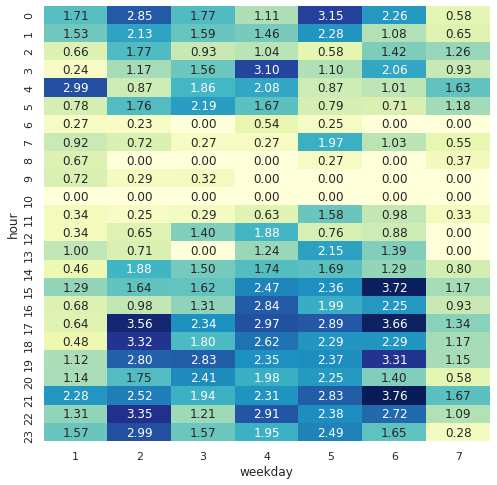

In [12]:
# Conversion rate by weekday and hour
sql = """
SELECT 
    EXTRACT(DAYOFWEEK FROM PARSE_DATE("%Y%m%d", date)) AS weekday,
    EXTRACT(HOUR FROM PARSE_TIMESTAMP("%s", CAST(visitStartTime AS STRING))) AS hour,
    100*SUM(totals.transactions)/SUM(totals.visits) AS conv_rate
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE 
    _TABLE_SUFFIX BETWEEN '20170701' AND '20170731'
GROUP BY 1,2
"""
slots = bquery(sql)

# Plot as a heatmap
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.heatmap(
    slots.pivot(index='hour', columns='weekday', values='conv_rate').fillna(0), 
    cmap="YlGnBu", annot=True, fmt='.2f', cbar=False);

## How many pageviews before reaching a Destination Goal

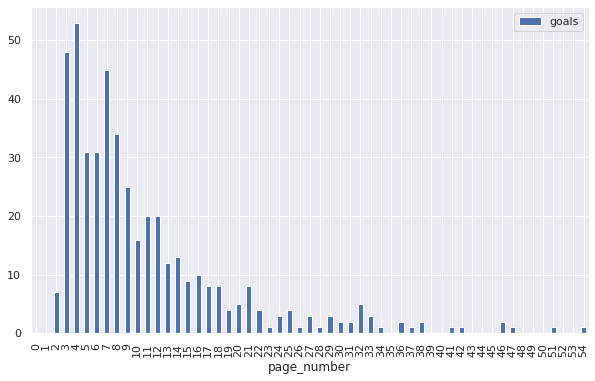

In [13]:
# Number of pages viewed in a session before reaching a Goal (destination page)
sql = """
WITH sub1 AS (
    SELECT 
        CONCAT(fullVisitorId, CAST(visitId AS STRING)) AS session_id,
        -- Window function to compute rank of each Page viewed in a session
        RANK() OVER (PARTITION BY fullVisitorId, visitId ORDER BY hits.hitNumber) AS page_number,
        hits.page.pagePath AS page
    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) AS hits
    WHERE 
        _TABLE_SUFFIX BETWEEN '20170701' AND '20170710'
        -- Filter on Pages only, we don't want all Hits types
        AND hits.type = 'PAGE'
    GROUP BY fullVisitorId, visitId, hits.hitNumber, page
)

SELECT 
    page_number,
    COUNT(*) AS goals
FROM sub1
-- Filter on the destination page associated with a Goal
WHERE page = '/registersuccess.html'
GROUP BY 1
ORDER BY 1
"""
goals_pages = bquery(sql)

# Plot distribution
(
    goals_pages
    .set_index('page_number')
    .reindex(list(range(0, max(goals_pages['page_number'])+1)))
    .plot(kind='bar', figsize=(10,6))
);